# ⭐🐟 GBR Prediction with Tracking + WBF (model ensemble) ⭐🐟
### By [Luca Ordronneau](https://www.kaggle.com/lucaordronneau)
# 📚 Import Librairies

In [1]:
import os
import sys
import ast
import time
import torch
import random
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import cv2
from PIL import Image
from IPython.display import display

# 📂 Variables

In [2]:
IMG_SIZE_1  = 5200
AUGMENT_1   = True
IOU_1       = 0.4
CONF_1      = 0.25

IMG_SIZE_2  = 6240
AUGMENT_2   = True
IOU_2       = 0.4
CONF_2      = 0.25

# 📌 Help functions

In [3]:
def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y2]
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes

def coco2voc(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes_yolo = coco2yolo(bboxes, image_height, image_width)
    bboxes_voc = yolo2voc(bboxes_yolo, image_height, image_width)
    return bboxes_voc

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y2]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [4]:
# norfair dependencies
%cd /kaggle/input/norfair031py3/
!pip install commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
!pip install rich-9.13.0-py3-none-any.whl

!mkdir /kaggle/working/tmp
!cp -r /kaggle/input/norfair031py3/filterpy-1.4.5/filterpy-1.4.5/ /kaggle/working/tmp/
%cd /kaggle/working/tmp/filterpy-1.4.5/
!pip install .
!rm -rf /kaggle/working/tmp

# norfair
%cd /kaggle/input/norfair031py3/
!pip install norfair-0.3.1-py3-none-any.whl -f ./ --no-index

/kaggle/input/norfair031py3
Looking in links: ./
Processing ./commonmark-0.9.1-py2.py3-none-any.whl
commonmark is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing ./rich-9.13.0-py3-none-any.whl
  Attempting uninstall: rich
    Found existing installation: rich 11.0.0
    Uninstalling rich-11.0.0:
      Successfully uninstalled rich-11.0.0
/kaggle/working/tmp/filterpy-1.4.5
Processing /kaggle/working/tmp/filterpy-1.4.5
  Preparing metadata (setup.py) ... - done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=316aa155583ebe5da09cfb42b09000bab912aec6d20a5418ec63d0752d7810f8
  Stored in directory: /root/.cache/pip/wheels/0e/ba/6d/20557ee403bc0c849d9fe3b358ded9918d7d2b0c5b0253fc99
Successfully built filterpy
/kaggle/input/norfair031py3
Looking in links: ./
Processing ./norfair-0.3.1-py3-none-any.whl


In [5]:
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

# Euclidean distance function to match detections on this frame with tracked_objects from previous frames
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

In [6]:
def load_model(model_path, conf=0.35, iou=0.50):
    model = torch.hub.load('/kaggle/input/yolov5','custom', path=model_path, source='local', force_reload=True)
    model.conf = conf
    model.iou  = iou
    model.classes = None
    model.multi_label = False
    model.max_det = 1000
    return model

In [7]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values # voc format
    if len(bboxes):
        bboxes  = bboxes.astype(int) # voc
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [], []

In [8]:
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf:.2f} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

In [9]:
!cp -r /kaggle/input/yolov5 /kaggle/working

In [10]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/fontarialyolov5/Arial.ttf /root/.config/Ultralytics/

In [11]:
import sys; sys.path.append('/kaggle/input/weightedboxesfusion/')

from ensemble_boxes import *

def run_wbf(bboxes, confs, image_size, iou_thr=0.5, skip_box_thr=0.001, weights=None):
    boxes  = [bbox/(image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]
    labels = [np.zeros(conf.shape[0]) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes  = boxes*(image_size-1)
    return boxes, scores, labels

def predict_wbf(img, model_1, model_2, image_size_1, image_size_2, augment_1, augment_2):
    height, width = img.shape[:2]
    bboxes_1, confs_1 = predict(model_1, img, image_size_1, augment_1)     
    bboxes_2, confs_2 = predict(model_2, img, image_size_2, augment_2)
    if len(bboxes_1) > 0 and len(bboxes_2) > 0:
        bboxes, confs, labels = run_wbf([bboxes_1, bboxes_2], [confs_1, confs_2], max(height, width))
        return voc2coco(bboxes, height, width).astype(int), confs
    elif len(bboxes_1) > 0:
        return voc2coco(bboxes_1, height, width).astype(int), confs_1 / 2
    elif len(bboxes_2) > 0:
        return voc2coco(bboxes_2, height, width).astype(int), confs_2 / 2
    else:
        return [], []

In [12]:
def draw_yolox_predictions(img, bboxes, scores, classes_dict):
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = 0
            score = scores[i]
            if score > 0.25:
                x0 = int(box[0])
                y0 = int(box[1])
                x1 = int(box[0]) + int(box[2])
                y1 = int(box[1]) + int(box[3])

                cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
                cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img

In [13]:
mM_path = "/kaggle/input/v53-l-s2-t640-v1280-sbsq-02-e16-b6-s1280/V53-L-S2-T640-V1280-SbSq-0.2-E16-B6-S1280.pt"
mS_path = "/kaggle/input/v75-1280valid-train-newdataset/v75-best.pt"

In [14]:
model_1 = load_model(mM_path, conf=CONF_1, iou=IOU_2)
model_2 = load_model(mS_path, conf=CONF_2, iou=IOU_2)

# 🔍 Prediction

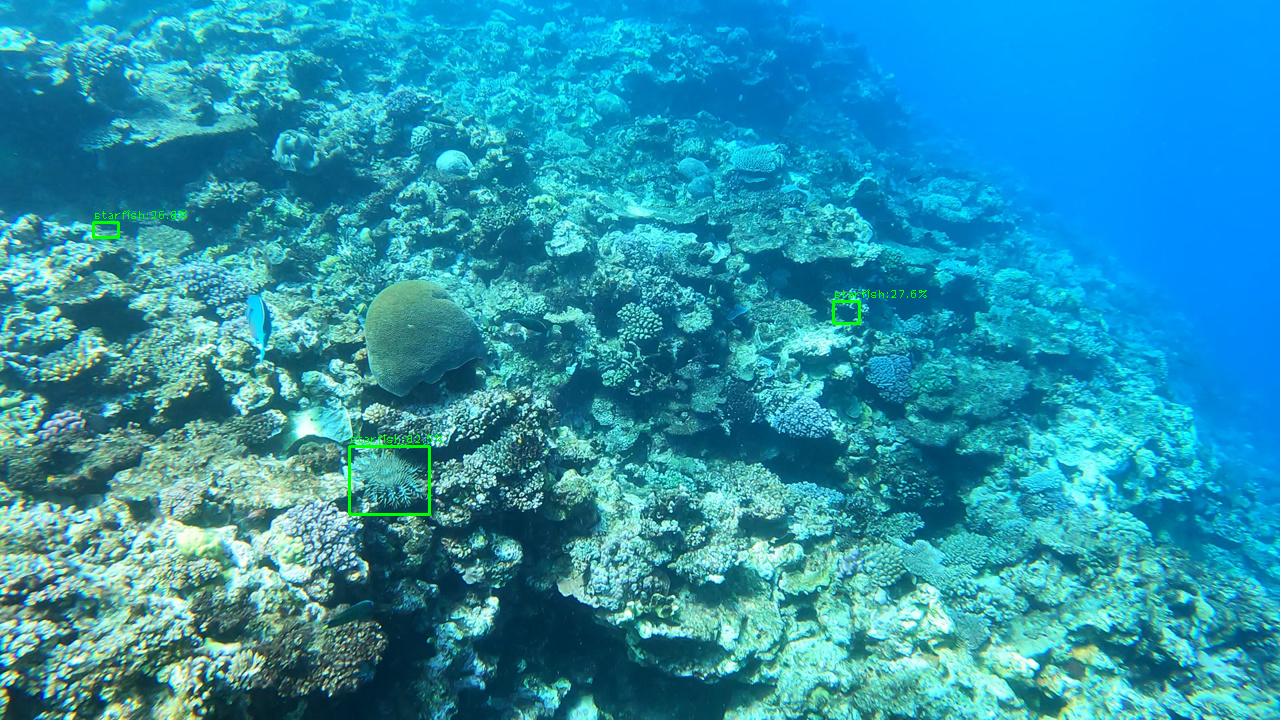

In [15]:
COCO_CLASSES = (
  "starfish",
)

TEST_IMAGE_PATH = "/kaggle/input/tensorflow-great-barrier-reef/train_images/video_0/89.jpg"

img = cv2.imread(TEST_IMAGE_PATH)
bboxes, scores = predict_wbf(img, model_1, model_2, IMG_SIZE_1, IMG_SIZE_2, AUGMENT_1, AUGMENT_2)

out_image = draw_yolox_predictions(img, bboxes, scores, COCO_CLASSES)

# Since we load image using OpenCV we have to convert it 
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

In [16]:
# from PIL import Image
# img = np.array(Image.open("/kaggle/input/tensorflow-great-barrier-reef/train_images/video_0/161.jpg"))
test = np.load("/kaggle/input/tensorflow-great-barrier-reef/example_test.npy")

tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

frame_id = 0

for img in test:
    bboxes, confs = predict_wbf(img, model_1, model_2, IMG_SIZE_1, IMG_SIZE_2, AUGMENT_1, AUGMENT_2)

    predictions = []
    detects     = []
    for i in range(len(bboxes)):
        box   = bboxes[i]        
        score = confs[i]

        if score > 0.16:

            x_min = int(box[0])
            y_min = int(box[1])
            x_max = int(box[0]) + int(box[2])
            y_max = int(box[1]) + int(box[3])

            detects.append([x_min, y_min, x_max, y_max, score])

            bbox_width  = int(box[2])
            bbox_height = int(box[3])

            predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))

    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue

        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))

    prediction_str = ' '.join(predictions)
    frame_id += 1

    print('Prediction:', prediction_str)

Prediction: 0.34 80 561 22 22 0.25 684 277 22 18 0.18 43 561 34 23 0.16 242 133 56 30
Prediction: 0.22 238 133 60 31 0.21 71 567 23 22
Prediction: 0.23 819 648 31 31 0.20 154 354 22 19 0.21 73 566 23 22 0.22 238 133 60 31


In [17]:
%cd /kaggle/working/

/kaggle/working


In [18]:
import greatbarrierreef
env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

In [19]:
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

frame_id = 0

In [20]:
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, confs = predict_wbf(img, model_1, model_2, IMG_SIZE_1, IMG_SIZE_2, AUGMENT_1, AUGMENT_2)
    
    predictions = []
    detects     = []
    for i in range(len(bboxes)):
        box   = bboxes[i]        
        score = confs[i]

        if score > 0.16:

            x_min = int(box[0])
            y_min = int(box[1])
            x_max = int(box[0]) + int(box[2])
            y_max = int(box[1]) + int(box[3])
            
            detects.append([x_min, y_min, x_max, y_max, score])
            
            bbox_width  = int(box[2])
            bbox_height = int(box[3])

            predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
    
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
            
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]
        
        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))

    prediction_str = ' '.join(predictions)
    frame_id += 1
    
    pred_df['annotations'] = prediction_str
    env.predict(pred_df)
    print('Prediction:', prediction_str)

0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Prediction: 0.34 80 561 22 22 0.25 684 277 22 18 0.18 43 561 34 23 0.16 242 133 56 30
Prediction: 0.22 238 133 60 31 0.21 71 567 23 22
Prediction: 0.23 819 648 31 31 0.20 154 354 22 19 0.21 73 566 23 22 0.22 238 133 60 31
